# Retail Sales Project

This dataset contains lot of historical sales data. It was extracted from a Brazilian top retailer and has many SKUs and many stores. The data was transformed to protect the identity of the retailer.

Descrição oficial do Dataset, que pode ser encontrado aqui:
[Retail Sales Forecasting](https://www.kaggle.com/datasets/tevecsystems/retail-sales-forecasting)

# Parte 1 - Preparação dos dados em Python

<span style="font-size: 18px;">Parte 1.1 - Importação de Pacotes que iremos utilizar e Exploração Inicial.</span>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#Importando o dataset.
df_sales = pd.read_csv('mock_kaggle_original.csv')

Vamos começar nossa análise e se atentar ao fato que:


O dataset carregado no BigQuery teve valores nulos removidos para simplificar as consultas e garantir consistência nos dados analisados na nuvem. Para análises locais, optamos por usar o dataset original para explorar abordagens alternativas de tratamento e identificar o impacto das diferenças no pipeline.

In [3]:
#Olhando a "cara" do nosso conjunto de dados
print(df_sales.head(5))
print(df_sales.shape)

         data  venda  estoque  preco
0  2014-01-01      0     4972   1.29
1  2014-01-02     70     4902   1.29
2  2014-01-03     59     4843   1.29
3  2014-01-04     93     4750   1.29
4  2014-01-05     96     4654   1.29
(937, 4)


Percebemos que trata-se de um dataset simples, de apenas 4 colunas e 937 linhas. Contudo, vamos analisar que mesmo datasets simples, podemos tirar insights valiosos e montar um grande projeto que percorre várias etapas.

In [4]:
df_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 937 entries, 0 to 936
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   data     937 non-null    object 
 1   venda    937 non-null    int64  
 2   estoque  937 non-null    int64  
 3   preco    937 non-null    float64
dtypes: float64(1), int64(2), object(1)
memory usage: 29.4+ KB


In [5]:
df_sales.isnull().sum()

data       0
venda      0
estoque    0
preco      0
dtype: int64

Observamos que não há valores nulos, dessa forma, temos o mesmo dataset para essa exploração inicial e o carregado no BigQuery.

In [6]:
df_sales.describe()

,venda,estoque,preco
count,937.000000,937.000000,937.000000
mean,90.533618,1608.258271,1.592572
std,80.682089,1356.691877,0.529502
min,0.000000,0.000000,0.000000
25%,33.000000,794.000000,1.290000
50%,76.000000,1348.000000,1.390000
75%,127.000000,1964.000000,1.890000
max,542.000000,7228.000000,2.980000


A análise sugere flutuações significativas na demanda e possíveis problemas de gestão de estoque e promoções.

In [7]:
#Verificando se houve vendas duplicadas. O esperado é que seja 0, pois, cada venda é única, mesmo que seja o "mesmo produto".
df_sales.duplicated().sum()

0

In [8]:
#Vamos explorar um pouco a soma de vendas por produtos.
#df_sales.groupby('produto').sum()

<span style="font-size: 18px;">Parte 1.2 - Visualização Visual e Outras Análises.</span>

In [9]:
#Configurações globais
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

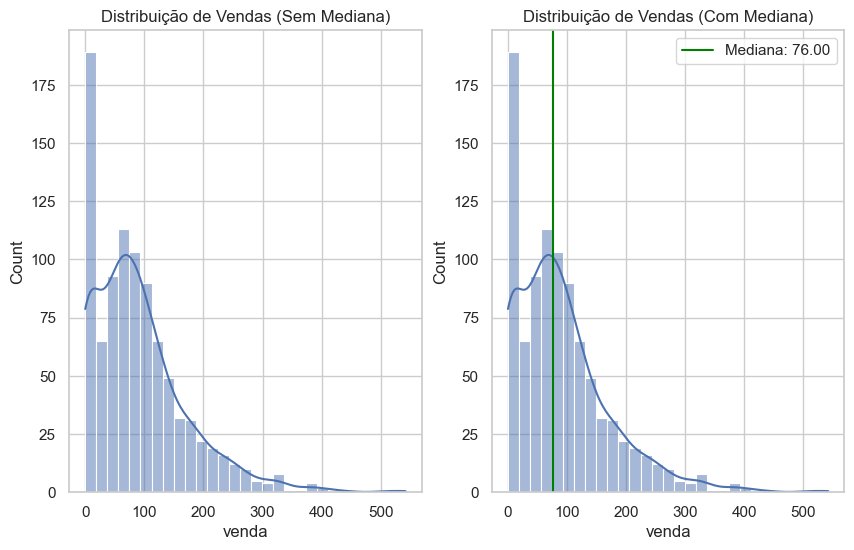

In [10]:
# Calculando a mediana
mediana = np.median(df_sales['venda'])

# Criando uma figura com dois subgráficos (1 linha e 2 colunas)
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

# Primeiro histplot sem a linha de mediana
sns.histplot(df_sales['venda'], kde=True, ax=axes[0])
axes[0].set_title("Distribuição de Vendas (Sem Mediana)")

# Segundo histplot com a linha de mediana
sns.histplot(df_sales['venda'], kde=True, ax=axes[1])
axes[1].axvline(mediana, color='green', linestyle='-', label=f'Mediana: {mediana:.2f}')
axes[1].set_title("Distribuição de Vendas (Com Mediana)")
axes[1].legend()

In [11]:
from scipy.stats import skew

skewness = df_sales['venda'].skew()
print(f"Assimetria: {skewness}")

Assimetria: 1.4269961297425253


Bom, assimetria é positiva, ou seja, a curva é inviesada pra direita e indica que houve muitos valores de venda baixos.

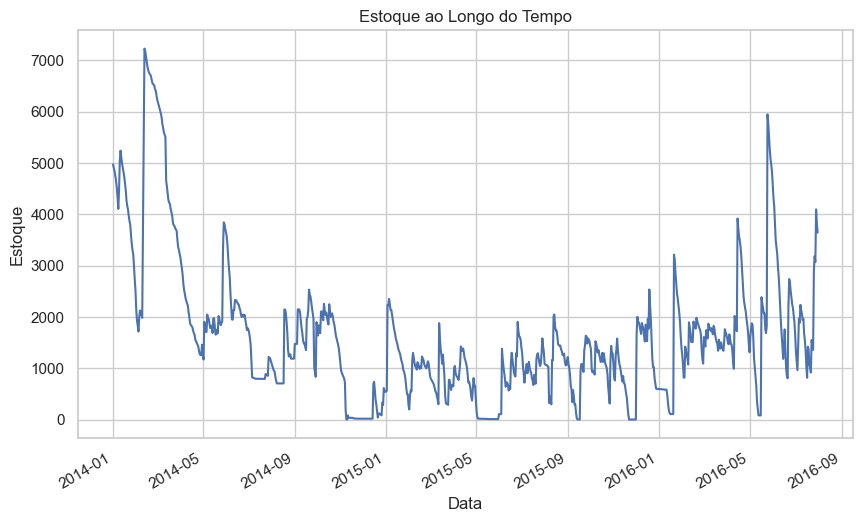

In [12]:
#Analisando o Estoque ao Longo do tempo.
df_sales['data'] = pd.to_datetime(df_sales['data'])  # Convertendo data
df_sales.set_index('data')['estoque'].plot()
plt.title("Estoque ao Longo do Tempo")
plt.xlabel("Data")
plt.ylabel("Estoque")
plt.show()


In [13]:
df_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 937 entries, 0 to 936
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   data     937 non-null    datetime64[ns]
 1   venda    937 non-null    int64         
 2   estoque  937 non-null    int64         
 3   preco    937 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 29.4 KB


Repare que a coluna data foi convertida corretamente. Também, por se tratar de um dataset mais simples, não há colunas categóricas.

In [14]:
#Verificar correlação.
df_sales[['venda', 'estoque']].corr()

,venda,estoque
venda,1.000000,0.153659
estoque,0.153659,1.000000


O estoque não é um fator limitante para as vendas (talvez sempre haja estoque suficiente).

As vendas dependem mais de fatores externos, como promoções ou sazonalidade, do que do nível de estoque.

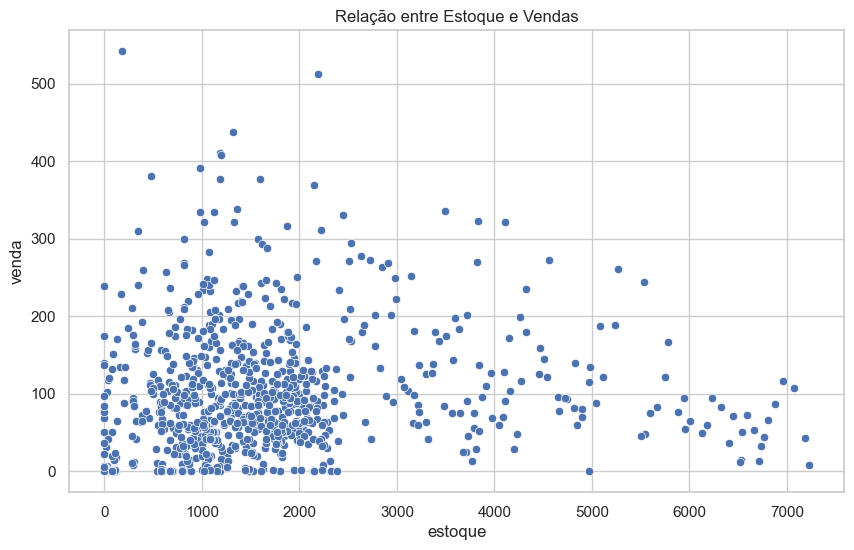

In [15]:
sns.scatterplot(data=df_sales, x='estoque', y='venda')
plt.title("Relação entre Estoque e Vendas")
plt.show()

<Axes: xlabel='data', ylabel='venda'>

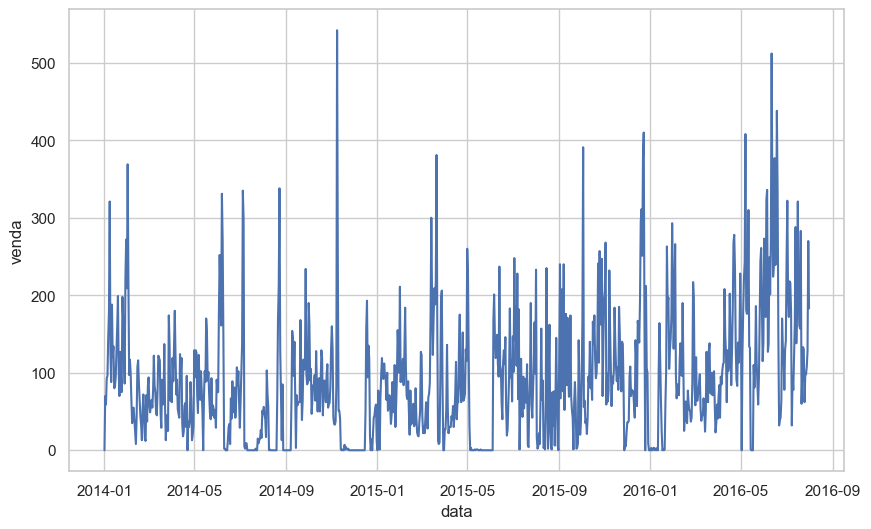

In [16]:
sns.lineplot(df_sales, x='data', y='venda')

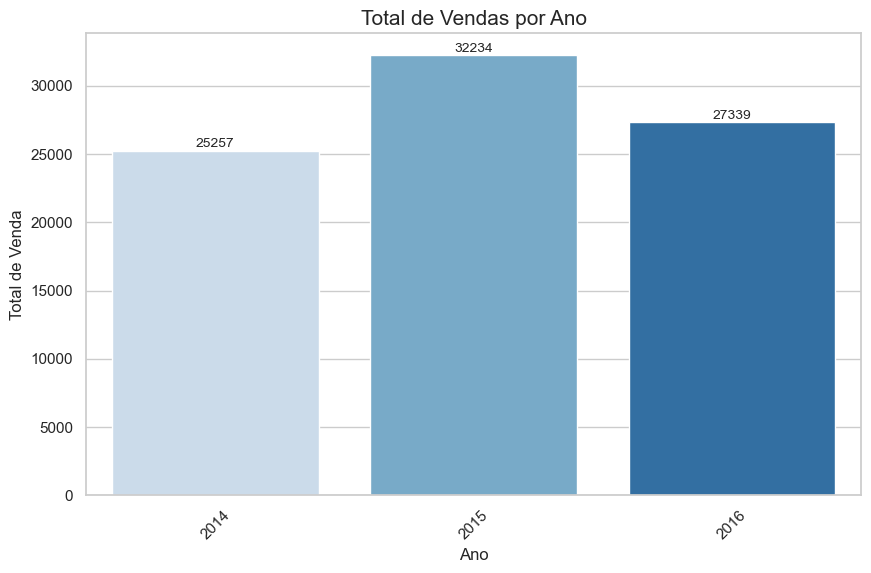

In [17]:
#Seguindo a exploração visual, vamos explorar como as vendas variam ao longo dos anos
x = df_sales['data'].dt.year
dados_p_ano = df_sales.groupby(x)['venda'].sum().reset_index()

sns.barplot(x='data', y='venda', data=dados_p_ano, palette='Blues')

# Adicionando os valores no topo das barras
for index, row in dados_p_ano.iterrows():
    plt.text(row.name, row['venda'] + 10, f"{row['venda']:.0f}", ha='center', va='bottom', fontsize=10)

# Adicionando título e rótulos
plt.title('Total de Vendas por Ano', fontsize=15)
plt.xlabel('Ano', fontsize=12)
plt.ylabel('Total de Venda', fontsize=12)
plt.xticks(rotation=45)
plt.show()

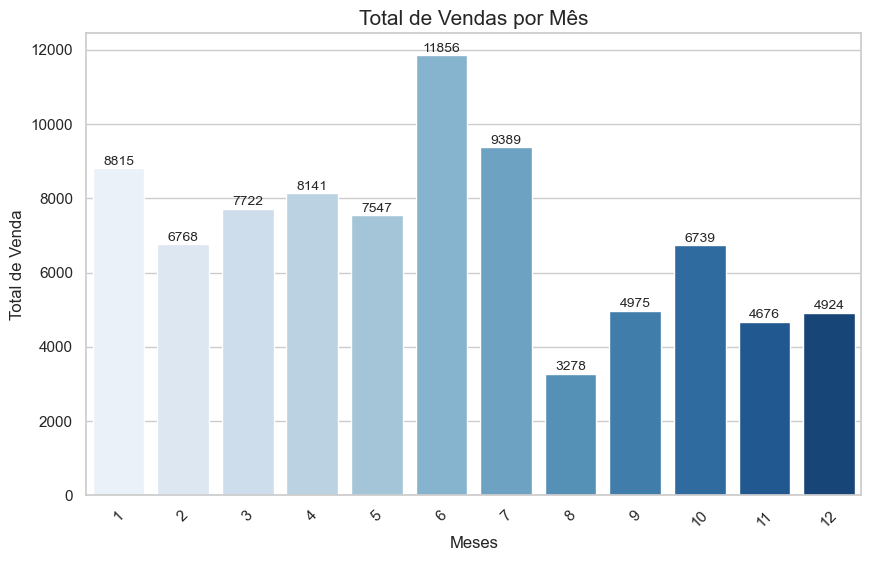

In [18]:
#Vamos aproveitar e também fazer o gráfico por mês.

#Seguindo a exploração visual, vamos explorar como as vendas variam ao longo dos meses
x = df_sales['data'].dt.month
dados_p_mes = df_sales.groupby(x)['venda'].sum().reset_index()

sns.barplot(x='data', y='venda', data=dados_p_mes, palette='Blues')

# Adicionando os valores no topo das barras
for index, row in dados_p_mes.iterrows():
    plt.text(row.name, row['venda'] + 10, f"{row['venda']:.0f}", ha='center', va='bottom', fontsize=10)

# Adicionando título e rótulos
plt.title('Total de Vendas por Mês', fontsize=15)
plt.xlabel('Meses', fontsize=12)
plt.ylabel('Total de Venda', fontsize=12)
plt.xticks(rotation=45)
plt.show()

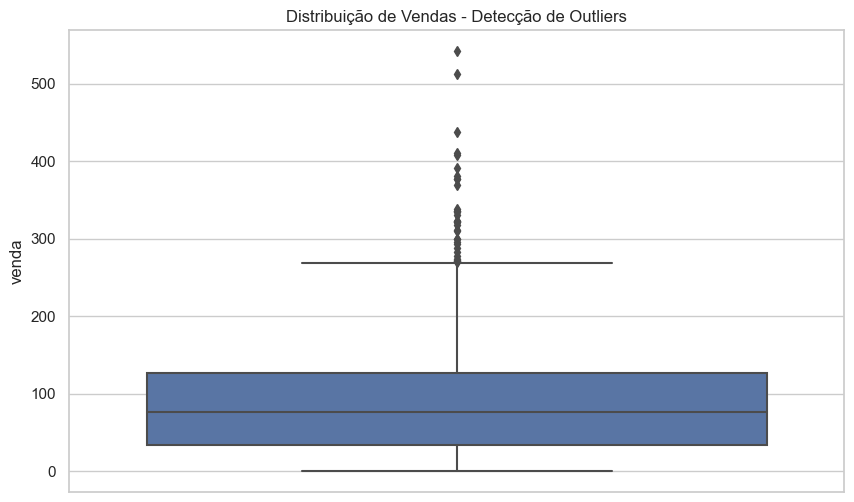

In [19]:
#Vamos verificar se há outliers antes de prosseguir.

sns.boxplot(y=df_sales['venda'])
plt.title('Distribuição de Vendas - Detecção de Outliers')
plt.show()

Em análises de vendas e produtos, os outliers podem fornecer insights valiosos. Mas vamos documenta-lo abaixo.

In [20]:
q1 = df_sales['venda'].quantile(0.25)
q3 = df_sales['venda'].quantile(0.75)

iqr = q3 - q1
limite_inferior = q1 - 1.5*iqr
limite_superior = q3 + 1.5*iqr

print(limite_inferior)
print(limite_superior)

-108.0
268.0


In [21]:
#Vamos criar uma coluna para os outliers

df_sales['Outlier'] = df_sales['venda'] > limite_superior
outlier_summary = df_sales[df_sales['Outlier']].groupby('data').sum()
#Resumo das vendas por data
print(outlier_summary)


            venda  estoque  preco  Outlier
data                                      
2014-01-08    321     4104   1.29        1
2014-01-30    272     2723   0.99        1
2014-02-01    369     2145   0.99        1
2014-06-07    331     2446   1.19        1
2014-06-08    271     2175   1.19        1
2014-07-05    335     1119   1.29        1
2014-07-06    299      820   1.29        1
2014-08-23    338     1356   1.19        1
2014-11-08    542      175   1.49        1
2015-03-14    300     1575   1.29        1
2015-03-21    381      475   1.29        1
2015-10-03    391      976   1.48        1
2015-12-19    295     2533   1.39        1
2015-12-20    311     2222   1.39        1
2015-12-22    377     1594   1.39        1
2015-12-23    410     1184   1.39        1
2016-01-30    293     1617   1.79        1
2016-04-22    278     2636   1.89        1
2016-05-07    408     1196   1.89        1
2016-05-11    310      348   1.38        1
2016-06-01    273     4558   2.59        1
2016-06-04 

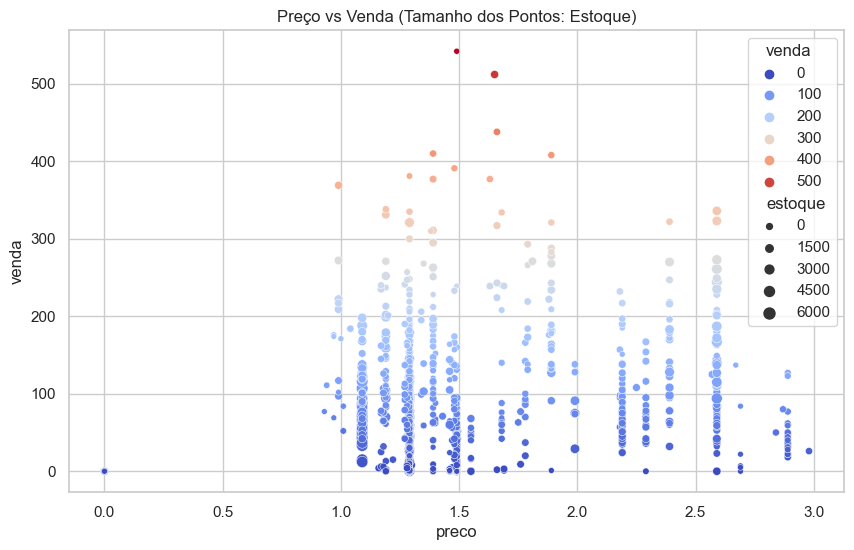

In [22]:
#Vamos análise de venda por preço

sns.scatterplot(x='preco', y='venda', size='estoque', data=df_sales, hue='venda', palette='coolwarm')
plt.title('Preço vs Venda (Tamanho dos Pontos: Estoque)')
plt.show()


Notamos uma correlação pequena.

# Parte 2 - Estabelecendo Conexões com BigQuery.

<span style="font-size: 18px;">Parte 2.1 - Criando conexões para utilizar a API.</span>

Configuração do Ambiente BigQuery. Para trabalhar com o BigQuery no Google Cloud usando Python, geramos uma chave JSON da conta de serviço. Essa chave permite a autenticação e o acesso seguro ao banco de dados no Cloud. Abaixo, definimos a variável de ambiente GOOGLE_APPLICATION_CREDENTIALS com o caminho do arquivo JSON baixado. Isso garante que as bibliotecas do Google Cloud consigam autenticar nossas solicitações de forma automática.


In [23]:
#!pip install google-cloud-bigquery
#!pip install db-dtypes
#!pip install --upgrade db-dtypes

In [24]:
#Estabelecendo conexão
import os


os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'arctic-nectar-443501-m3-6f9b001f85f2.json'


In [25]:
#Estabelecendo conexão

import db_dtypes
from google.cloud import bigquery

client = bigquery.Client()

# Query SQL para buscar os dados
query = """
SELECT * 
FROM `arctic-nectar-443501-m3.retail_sales.TABLE_FINAL`
LIMIT 1000
"""

# Executar a consulta e armazenar os resultados em um DataFrame
df = client.query(query).to_dataframe()

print(df.head())


         data  venda  estoque  preco
0  2015-12-05    108     1893   2.25
1  2015-09-12    171      129   1.00
2  2015-09-10    176      288   0.97
3  2015-09-16    174        0   0.97
4  2015-09-14     69        0   0.97


<span style="font-size: 18px;">Parte 2.2 - Conectando com as Views Criadas.</span>

Veficando a receita total por mês / ano.

In [26]:
query = """
SELECT * 
FROM `arctic-nectar-443501-m3.retail_sales.view_receitatotal`
"""
df_receita_mensal = client.query(query).to_dataframe()
print(df_receita_mensal.head(50))


     ano  mes  receita_total
0   2014    1        4528.55
1   2014    2        2182.82
2   2014    3        2536.76
3   2014    4        2297.30
4   2014    5        3241.91
5   2014    6        3328.54
6   2014    7        1527.10
7   2014    8        1849.36
8   2014    9        2818.65
9   2014   10        3609.25
10  2014   11        2176.78
11  2014   12        1312.70
12  2015    1        3242.85
13  2015    2        3678.52
14  2015    3        5096.51
15  2015    4        3025.50
16  2015    5         899.83
17  2015    6        3686.01
18  2015    7        4006.08
19  2015    8        2346.27
20  2015    9        3816.26
21  2015   10        5718.14
22  2015   11        6434.45
23  2015   12        6652.04
24  2016    1        3621.98
25  2016    2        5991.70
26  2016    3        5193.14
27  2016    4        9514.12
28  2016    5        9860.05
29  2016    6       13331.61
30  2016    7       11363.06


Verificando Volume Médio

In [27]:
query = """
SELECT *
FROM `arctic-nectar-443501-m3.retail_sales.view_volumemedio`

"""

df_volume = client.query(query).to_dataframe()
print(df_volume.head())

  faixa_preco  volume_medio_vendas
0        Alto           112.435374
1       Baixo            96.173913
2       Médio            79.938710


Da mesma forma, verificando maior e menor estoque.

In [28]:
query = """
SELECT *
FROM `arctic-nectar-443501-m3.retail_sales.view_estoqueminmax`

"""

df_estoque = client.query(query).to_dataframe()
print(df_estoque.head())

            tipo        data  estoque
0  Menor Estoque  2015-09-16        0
1  Maior Estoque  2014-02-12     7228


# Parte 3 - Machine Learning e Engenharia de Features

<span style="font-size: 18px;">Parte 3.1 - Engenharia de Features.</span>

Estamos lidando com um dataset simples. Para fazer previsões legais e deixar o modelo de previsão mais robusto, vamos incluir mais features.

In [29]:
#Importando pacotes de machine learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder

In [30]:
#Criando features adicionais

df_sales['mes'] = df_sales['data'].dt.month
df_sales['ano'] = df_sales['data'].dt.year

In [31]:
#Preparar os dados para treino

In [32]:
df_sales

,data,venda,estoque,preco,Outlier,mes,ano
0,2014-01-01,0,4972,1.29,False,1,2014
1,2014-01-02,70,4902,1.29,False,1,2014
2,2014-01-03,59,4843,1.29,False,1,2014
3,2014-01-04,93,4750,1.29,False,1,2014
4,2014-01-05,96,4654,1.29,False,1,2014
...,...,...,...,...,...,...,...
932,2016-07-27,98,3179,2.39,False,7,2016
933,2016-07-28,108,3071,2.39,False,7,2016
934,2016-07-29,128,4095,2.39,False,7,2016
935,2016-07-30,270,3825,2.39,True,7,2016


Como estamos trabalhando com vendas, uma boa forma de analisar vendas futuras é deslocando as vendas para que a linha atual contenha as variáveis independentes (preco, estoque, ...) e a venda do próximo como alvo.

Adicionando esse lag, a ideia é prever a venda do próximo mês com base em dados anteriores.

In [33]:
df_sales['vendas_futuras'] = df_sales['venda'].shift(-1)

Agora podemos treinar nosso modelo, vamos definir a variável 'vendas_futuras' como a variável alvo. Eis alguns motivos:

1. Ajuda a estimar a demanda futura, essencial para planejamento de estoques e promoções.

2. Permite identificar tendências sazonais com base nas colunas mes e ano.

In [34]:
#Completando o dataframe com as views; vamos utilizar a de receita total
df_sales = df_sales.merge(df_receita_mensal, on=['ano', 'mes'], how='left')

In [35]:
# Verificando as colunas
print(df_sales.columns)

# Remover a coluna '_x' e manter a '_y'
#df_sales.drop(columns=['receita_total_x'], inplace=True)

# Renomear a coluna restante para 'receita_total'
#df_sales.rename(columns={'receita_total_y': 'receita_total'}, inplace=True)

# Verificando o DataFrame final
#print(df_sales.head())


Index(['data', 'venda', 'estoque', 'preco', 'Outlier', 'mes', 'ano',
       'vendas_futuras', 'receita_total'],
      dtype='object')


In [36]:
df_sales

,data,venda,estoque,preco,Outlier,mes,ano,vendas_futuras,receita_total
0,2014-01-01,0,4972,1.29,False,1,2014,70.0,4528.55
1,2014-01-02,70,4902,1.29,False,1,2014,59.0,4528.55
2,2014-01-03,59,4843,1.29,False,1,2014,93.0,4528.55
3,2014-01-04,93,4750,1.29,False,1,2014,96.0,4528.55
4,2014-01-05,96,4654,1.29,False,1,2014,145.0,4528.55
...,...,...,...,...,...,...,...,...,...
932,2016-07-27,98,3179,2.39,False,7,2016,108.0,11363.06
933,2016-07-28,108,3071,2.39,False,7,2016,128.0,11363.06
934,2016-07-29,128,4095,2.39,False,7,2016,270.0,11363.06
935,2016-07-30,270,3825,2.39,True,7,2016,183.0,11363.06


In [37]:
#Vamos criar faixa de valores para o dataframe, pra ficar igual a  view. Vamos utilizar os preços.

def faixa_precos(preco):
    if preco <= 1:
        return 'Baixo'
    elif preco > 1 and preco <=2:
        return 'Médio'
    else:
        return 'Alto'
    
df_sales['faixa_precos'] = df_sales.apply(lambda row: faixa_precos(row['preco']), axis=1)
#df_sales['faixa_precos'] = df_sales['preco'].apply(faixa_precos) outro jeito de fazer


Vamos fazer o mesmo para Volume Medio de Vendas. Aqui o foco é sempre enriquecer nosso dataframe, que começou simples e estamos deixando mais robusto.

In [38]:
volume_dict = df_volume.set_index('faixa_preco')['volume_medio_vendas'].to_dict()

In [39]:
volume_dict

{'Alto': 112.43537414965994,
 'Baixo': 96.17391304347828,
 'Médio': 79.9387096774194}

In [40]:
df_sales['volume_medio'] = df_sales['faixa_precos'].map(volume_dict)


In [41]:
df_sales

,data,venda,estoque,preco,Outlier,mes,ano,vendas_futuras,receita_total,faixa_precos,volume_medio
0,2014-01-01,0,4972,1.29,False,1,2014,70.0,4528.55,Médio,79.938710
1,2014-01-02,70,4902,1.29,False,1,2014,59.0,4528.55,Médio,79.938710
2,2014-01-03,59,4843,1.29,False,1,2014,93.0,4528.55,Médio,79.938710
3,2014-01-04,93,4750,1.29,False,1,2014,96.0,4528.55,Médio,79.938710
4,2014-01-05,96,4654,1.29,False,1,2014,145.0,4528.55,Médio,79.938710
...,...,...,...,...,...,...,...,...,...,...,...
932,2016-07-27,98,3179,2.39,False,7,2016,108.0,11363.06,Alto,112.435374
933,2016-07-28,108,3071,2.39,False,7,2016,128.0,11363.06,Alto,112.435374
934,2016-07-29,128,4095,2.39,False,7,2016,270.0,11363.06,Alto,112.435374
935,2016-07-30,270,3825,2.39,True,7,2016,183.0,11363.06,Alto,112.435374


Vamos trabalhar com o Estoque também para ver se gera insights valiosos e impacta nosso modelo. Como o Estoque mín é 0. Vamos criar um percentual.

$$
percentual\_estoque = \left( \frac{estoque\ atual}{estoque\ máximo} \right) \times 100
$$

"Baixo" se o percentual é inferior a 20%.

"Normal" se o percentual está entre 20% e 80%.

"Alto" se o percentual é superior a 80%.


In [42]:
#7228 é o estoque máximo calculado com SQL no BigQuery
df_sales['percentual_estoque'] = (df_sales['estoque'] / 7228)*100

def categorizar_percentual(percentual):
    if percentual <= 20:
        return 'Baixo'
    elif percentual >= 80:
        return 'Alto'
    else:
        return 'Médio'
df_sales['categoria_estoque'] = df_sales['percentual_estoque'].apply(categorizar_percentual)


In [43]:
df_sales.columns

Index(['data', 'venda', 'estoque', 'preco', 'Outlier', 'mes', 'ano',
       'vendas_futuras', 'receita_total', 'faixa_precos', 'volume_medio',
       'percentual_estoque', 'categoria_estoque'],
      dtype='object')

Agora temos variável categórias, vamos aplicar <i><b>OneHotEncoder</b></i> para jogar tudo no nosso modelo de predição.

In [44]:
#OneHotEncoder e também deixar em 0 e 1 a coluna de Outlier

df_sales['Outlier'] = df_sales['Outlier'].astype(int)  #0 ou 1

#OneHotEncoder nas colunas 'faixa_precos' e 'categoria_estoque'
colunas_categoricas = ['faixa_precos', 'categoria_estoque']
enc = OneHotEncoder(drop='first', sparse_output=False)
data = enc.fit_transform(df_sales[colunas_categoricas])
df_sales_enc = pd.DataFrame(data, columns=enc.get_feature_names_out(), dtype=int)

#Juntanto duo em df_sales:
df_sales = pd.concat([df_sales, df_sales_enc], axis=1)

# Removendo as colunas categóricas originais
df_sales.drop(columns=colunas_categoricas, inplace=True)

Também poderiamos ter usado o próprio pandas para realizar com OneHotEncoder, com o método get_dummies(). Mas obtamos pelo OneHotEncoder por ser preferível em modelos de machine learning.

In [45]:
#Bom depois de ter 'shiftado' a coluna vendas para criar a coluna vendas_futuras, precisamos excluir o NaN dessa coluna
df_sales = df_sales.dropna(subset=['vendas_futuras'])

Vamos shiftar a coluna estoque também e gerar a coluna 'estoque_futuro'.

In [46]:
df_sales.loc[:, 'estoque_futuro'] = df_sales['estoque'].shift(-1) #modificando o dataframe original

Agora também remover a ultima linha, onde há conteúdo NaN para 'estoque_futuro'

In [47]:
df_sales = df_sales.dropna(subset=['estoque_futuro'])

<span style="font-size: 18px;">Parte 3.2 - Machine Learning.</span>

Finalmente, vamos adentrar na parte de Machine Learning e começar predizer nossas vendas futuras (variável alvo).
Alguns pacotes já foram importados acima, se necessitar de mais algum, farei a importação abaixo.

In [48]:
#Vamos treinar nosso modelo
X = df_sales.drop(columns=['data', 'vendas_futuras']) 
y = df_sales['vendas_futuras']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

<i><b>LinearRegression.</b></i>

In [49]:
reg = LinearRegression().fit(X_train, y_train)

In [50]:
# Fazer previsões
y_pred_reg = reg.predict(X_test)

In [51]:
rmse = mean_squared_error(y_test, y_pred_reg)
r2 = r2_score(y_test, y_pred_reg)

print(f'RMSE: {rmse}')
print(f'R²: {r2}')

RMSE: 3038.801886711423
R²: 0.5776420528943368


<i><b>RandomForest.</b></i>

In [52]:
from sklearn.ensemble import RandomForestRegressor

In [53]:
regr = RandomForestRegressor(max_depth=5, random_state=42, n_estimators=100).fit(X_train,y_train)

In [54]:
y_pred_regr = regr.predict(X_test)

In [55]:
rmse = mean_squared_error(y_test, y_pred_regr)
r2 = r2_score(y_test, y_pred_regr)

print(f'RMSE: {rmse}')
print(f'R²: {r2}')

RMSE: 3303.4118967445693
R²: 0.5408643540552214


Vamos aplicar <i><b>GridSearchCV</b></i> para descobrir os melhores parâmetros.

In [56]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],           # Número de árvores
    'max_depth': [2, 5, 10],                    # Profundidade das árvores
    'min_samples_split': [2, 5, 10],            # Mínimo de amostras para dividir um nó
    'min_samples_leaf': [1, 2, 5],              # Mínimo de amostras por folha
    'max_features': ['sqrt', 'log2'],           # Alterando de 'auto' para 'sqrt' ou 'log2'
    'bootstrap': [True, False]                  # Amostragem com reposição
}

# Inicializando o GridSearchCV com validação cruzada de 5 (cv)
grid_search = GridSearchCV(estimator=regr, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Treinando o modelo com validação cruzada
grid_search.fit(X_train, y_train)
print("Melhores parâmetros encontrados:", grid_search.best_params_)

Melhores parâmetros encontrados: {'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}


C:\Users\jrodr\anaconda3\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [57]:
#Agora que temos os melhores parâmetros, vamos testar.

# Usando o melhor modelo encontrado pelo GridSearchCV
melhor_modelo = grid_search.best_estimator_


y_pred_otimizado = melhor_modelo.predict(X_test)

rmse_otimizado = mean_squared_error(y_test, y_pred_otimizado, squared=False)  # RMSE
r2_otimizado = r2_score(y_test, y_pred_otimizado)                             # R²

# Exibindo os resultados
print(f'RMSE do modelo otimizado: {rmse_otimizado}')
print(f'R² do modelo otimizado: {r2_otimizado}')

C:\Users\jrodr\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


RMSE do modelo otimizado: 55.837240454494356
R² do modelo otimizado: 0.5666625967867965


Aqui com o modelo otimizado, notamos um claro caso de overfitting

Vamos visusalizar as variáveis mais importantes.

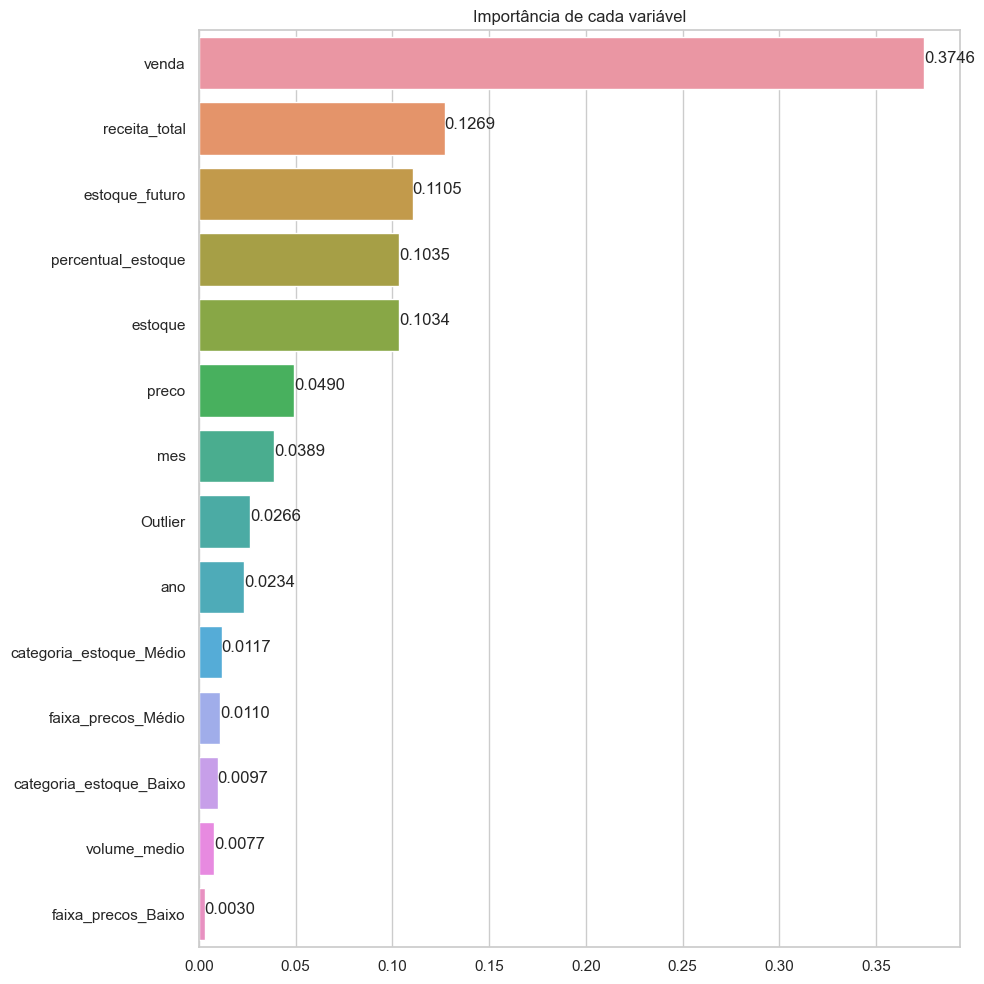

In [58]:
# Obtendo a importância das variáveis a partir do modelo otimizado
importances = pd.Series(data=melhor_modelo.feature_importances_, index=X.columns)

# Ordenando as importâncias em ordem decrescente
importances = importances.sort_values(ascending=False)

# Exibindo o gráfico de barras
plt.rcParams["figure.figsize"] = [10.00, 10.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(x=importances, y=importances.index, orient='h').set_title('Importância de cada variável')

# Adicionando os valores de importância no gráfico
for index, value in enumerate(importances):
    plt.text(value, index, f'{value:.4f}')

plt.show()


Vamos continuar com <i><b>Engenharia de variáveis</b></i>, vamos ajustar a escala do modelo e excluir algumas variáveis com pouco impacto.

Utilizaremos <i><b>StandardScaler</b></i>, pois ele trata melhor situações com grandes variações e distribuições desconhecidas.

In [59]:
from sklearn.preprocessing import StandardScaler

In [60]:
X = df_sales.drop(columns=['vendas_futuras', 'data'])
y = df_sales['vendas_futuras']

# Lista de colunas contínuas
colunas_continuas = ['estoque', 'preco', 'receita_total', 'volume_medio', 'percentual_estoque', 'estoque_futuro']

# Aplicando o StandardScaler nas variáveis contínuas
scaler = StandardScaler()
X_scaler_continuas = scaler.fit_transform(X[colunas_continuas])

# Reconstruindo o DataFrame com variáveis escaladas
X_scaler = pd.DataFrame(X_scaler_continuas, columns=colunas_continuas)

# Incluindo as colunas categóricas (já codificadas com OneHotEncoder)
colunas_categoricas = [col for col in X.columns if col not in colunas_continuas]
X_scaler[colunas_categoricas] = X[colunas_categoricas].reset_index(drop=True)


Agora passaremos usar o X_scaler como nosso dataframe de features principal, vamos treina-lo novamente.

In [61]:
X_scaler

,estoque,preco,receita_total,volume_medio,percentual_estoque,estoque_futuro,venda,Outlier,mes,ano,faixa_precos_Baixo,faixa_precos_Médio,categoria_estoque_Baixo,categoria_estoque_Médio
0,2.487952,-0.569287,0.017214,-0.556617,2.487952,2.441726,0,0,1,2014,0,1,0,1
1,2.436247,-0.569287,0.017214,-0.556617,2.436247,2.398064,70,0,1,2014,0,1,0,1
2,2.392667,-0.569287,0.017214,-0.556617,2.392667,2.329242,59,0,1,2014,0,1,0,1
3,2.323974,-0.569287,0.017214,-0.556617,2.323974,2.258199,93,0,1,2014,0,1,0,1
4,2.253064,-0.569287,0.017214,-0.556617,2.253064,2.150896,96,0,1,2014,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
930,-0.181493,1.512089,2.347204,1.864127,-0.181493,0.955014,62,0,7,2016,0,0,1,0
931,0.952319,1.512089,2.347204,1.864127,0.952319,1.166661,97,0,7,2016,0,0,0,1
932,1.163570,1.512089,2.347204,1.864127,1.163570,1.086739,98,0,7,2016,0,0,0,1
933,1.083797,1.512089,2.347204,1.864127,1.083797,1.844525,108,0,7,2016,0,0,0,1


In [62]:
#Vamos treinar nosso modelo
X_train, X_test, y_train, y_test = train_test_split(X_scaler, y, test_size=0.2, random_state=42)

<i><b>LinearRegression.</b></i>

In [63]:
reg = LinearRegression().fit(X_train, y_train)

In [64]:
# Fazer previsões
y_pred_reg = reg.predict(X_test)

In [65]:
rmse = mean_squared_error(y_test, y_pred_reg)
r2 = r2_score(y_test, y_pred_reg)

print(f'RMSE: {rmse}')
print(f'R²: {r2}')

RMSE: 3038.801886711795
R²: 0.577642052894285


<i><b>RandomForest.</b></i>

In [66]:
regr = RandomForestRegressor(max_depth=5, random_state=42, n_estimators=100).fit(X_train, y_train)

In [67]:
y_pred_regr = regr.predict(X_test)

In [68]:
rmse = mean_squared_error(y_test, y_pred_regr)
r2 = r2_score(y_test, y_pred_regr)

print(f'RMSE: {rmse}')
print(f'R²: {r2}')

RMSE: 3312.512816316959
R²: 0.5395994325991116


<i><b>GridSearchCV</b></i>

In [69]:
param_grid = {
    'n_estimators': [100, 200, 300],           # Número de árvores
    'max_depth': [2, 5, 10],                    # Profundidade das árvores
    'min_samples_split': [2, 5, 10],            # Mínimo de amostras para dividir um nó
    'min_samples_leaf': [1, 2, 5],              # Mínimo de amostras por folha
    'max_features': ['sqrt', 'log2'],           # Alterando de 'auto' para 'sqrt' ou 'log2'
    'bootstrap': [True, False]                  # Amostragem com reposição
}

# Inicializando o GridSearchCV com validação cruzada de 5 (cv)
grid_search = GridSearchCV(estimator=regr, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Treinando o modelo com validação cruzada
grid_search.fit(X_train, y_train)
print("Melhores parâmetros encontrados:", grid_search.best_params_)

C:\Users\jrodr\anaconda3\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Melhores parâmetros encontrados: {'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


In [70]:
#Agora que temos os melhores parâmetros, vamos testar.

# Usando o melhor modelo encontrado pelo GridSearchCV
melhor_modelo_pt2 = grid_search.best_estimator_


y_pred_otimizado = melhor_modelo_pt2.predict(X_test)

rmse_otimizado = mean_squared_error(y_test, y_pred_otimizado, squared=False)  # RMSE
r2_otimizado = r2_score(y_test, y_pred_otimizado)                             # R²

# Exibindo os resultados
print(f'RMSE do modelo otimizado: {rmse_otimizado}')
print(f'R² do modelo otimizado: {r2_otimizado}')

RMSE do modelo otimizado: 55.86136139675422
R² do modelo otimizado: 0.5662881239773074


C:\Users\jrodr\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Vou voltar o modelo como estava, pois, estava apresentando levemente melhores resultados.

In [71]:
#Vamos treinar nosso modelo
X = df_sales.drop(columns=['data', 'vendas_futuras']) 
y = df_sales['vendas_futuras']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

reg = LinearRegression().fit(X_train, y_train)

# Fazer previsões
y_pred_reg = reg.predict(X_test)

rmse = mean_squared_error(y_test, y_pred_reg)
r2 = r2_score(y_test, y_pred_reg)

print(f'RMSE: {rmse}')
print(f'R²: {r2}')

regr = RandomForestRegressor(max_depth=5, random_state=42, n_estimators=100).fit(X_train,y_train)
y_pred_regr = regr.predict(X_test)
rmse = mean_squared_error(y_test, y_pred_regr)
r2 = r2_score(y_test, y_pred_regr)

print(f'RMSE: {rmse}')
print(f'R²: {r2}')

#Vamos salvar os modelos acima
import joblib
joblib.dump(reg, "linear_regression.pkl")
joblib.dump(regr, "random_forest.pkl")

RMSE: 3038.801886711423
R²: 0.5776420528943368
RMSE: 3303.4118967445693
R²: 0.5408643540552214


['random_forest.pkl']

In [74]:
#Passando para csv, para utilizar no streamlit
X_test.to_csv('X_test.csv', index=False)
y_test.to_csv('y_test.csv', index=False)
